# Grover

In [10]:
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.circuit.library import UnitaryGate, ZGate
from qiskit.visualization import *
from qiskit_aer import *
import qiskit.quantum_info as qi


import numpy as np
from math import pi,log2,sqrt


# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Choosing local simulation to run circuits
service = QiskitRuntimeService(channel="local")

## Oracle

In [11]:
def f(x):
    if x==3:
        return 1
    return 0

def ket_reg(n,x):
    if x < 0 or x > 2**n-1:
        return(-1)
    output = [[0] for i in range(x)]+[[1]]+ [[0] for i in range(2**n-x-1)]
    return(np.matrix(output))

def bra_reg(n,x):
    return(ket_reg(n,x).H)



def XOROracle(n,f):
    unitary = np.matrix([[0 for i in range(2**(n+1))] for j in range(2**(n+1))])
    for b in range(2**n):
        if f(b)==0:
            unitary += np.kron(np.matrix([[1,0],[0,1]]),ket_reg(n,b) @ bra_reg(n,b))
        else:
            unitary += np.kron(np.matrix([[0,1],[1,0]]),ket_reg(n,b) @ bra_reg(n,b))
    return(UnitaryGate(unitary,label='XOR Oracle'))

def PhaseOracle2(n,f):
    output = QuantumCircuit(n+1,name='Phase Oracle')
    for i in range(n):
        output.h(i)
    output.append(XOROracle(n,f),list(range(n+1)))
    for i in range(n):
        output.h(i)
    return(output)
#PhaseOracle(2,f).draw(output='mpl')

def PhaseOracle(n,f):
    unitary = np.matrix([[0 for i in range(2**(n+1))] for j in range(2**(n+1))])
    for b in range(2**n):
        if f(b)==0:
            unitary += np.kron(np.matrix([[1,0],[0,1]]),ket_reg(n,b) @ bra_reg(n,b))
        else:
            unitary += np.kron(np.matrix([[1,0],[0,-1]]),ket_reg(n,b) @ bra_reg(n,b))
    return UnitaryGate(unitary,label='Phase Oracle')

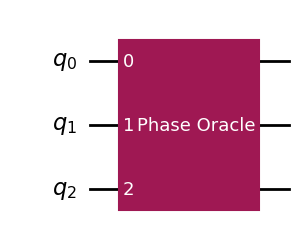

In [12]:
#Changing the simulator 
backend = Aer.get_backend('unitary_simulator')

#The circuit without measurement
circ = QuantumCircuit(3)

#circ.h(2)

circ.append(PhaseOracle(2,f),[0,1,2])

#circ.h(2)
circ.draw(output='mpl')


In [13]:
# Run and get unitary
circ=transpile(circ,backend)
result = backend.run(circ).result()
unitary = result.get_unitary(circ)
print("Circuit unitary:\n", np.asarray(unitary).round(5))



Circuit unitary:
 [[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


In [43]:
def CZ(n):
    return ZGate.control(num_ctrl_qubits=n, label = None, ctrl_state = None, annotated = False)

In [83]:
def GroverDiffusion(n):
    D = QuantumCircuit(n,name='Grover Diffusion')
    CZ = ZGate().control(n-1, "Controlled Z")
    for i in range(n):
        D.h(i)
        D.x(i)
   
    D.append(CZ,list(range(n-1,-1,-1)))

    for i in range(n):
        D.x(i)
        D.h(i)
    return D

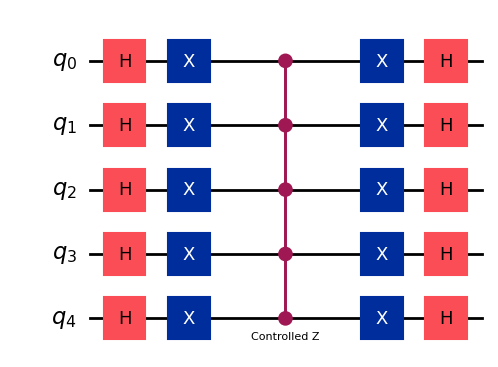

In [84]:
GroverDiffusion(5).draw(output='mpl')

In [85]:
circ = GroverDiffusion(3)
circ=transpile(circ,backend)
result = backend.run(circ).result()
unitary = result.get_unitary(circ)
print("Circuit unitary:\n", np.asarray(unitary).round(5))


Circuit unitary:
 [[ 0.75+0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j
  -0.25-0.j]
 [-0.25-0.j  0.75+0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j
  -0.25-0.j]
 [-0.25-0.j -0.25-0.j  0.75+0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j
  -0.25-0.j]
 [-0.25-0.j -0.25-0.j -0.25-0.j  0.75+0.j -0.25-0.j -0.25-0.j -0.25-0.j
  -0.25-0.j]
 [-0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j  0.75+0.j -0.25-0.j -0.25-0.j
  -0.25-0.j]
 [-0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j  0.75+0.j -0.25-0.j
  -0.25-0.j]
 [-0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j  0.75+0.j
  -0.25-0.j]
 [-0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j -0.25-0.j
   0.75+0.j]]


In [93]:
def GroverIter(n,f):
    x = QuantumRegister(n,name='x')
    y = QuantumRegister(1,name='y')
    o = ClassicalRegister(n,name='output')
    GroverIter = QuantumCircuit(x,y,name='Grover Iteration')
    
    GroverIter.append(PhaseOracle(n,f),list(range(n+1)))
   
    GroverIter.barrier()

    GroverIter.append(GroverDiffusion(n),list(range(n)))

    GroverIter.barrier()
    return GroverIter

def Grover(n,f,k):
    x = QuantumRegister(n,name='x')
    y = QuantumRegister(1,name='y')
    o = ClassicalRegister(n,name='output')
    Grover =  QuantumCircuit(x,y,o)
    
    #Prepare |1> state in |y>
    Grover.x(y)
    #Grover.h(y)
    Grover.barrier() 

    #Build total superposition of input
    for i in range(n):
        Grover.h(i)

    loops = int(pi/4*sqrt(2**n/k))+1

    for i in range(loops):
        Grover.append(GroverIter(n,f),range(n+1))

    Grover.barrier()
    
    Grover.measure(x,o)
    return Grover

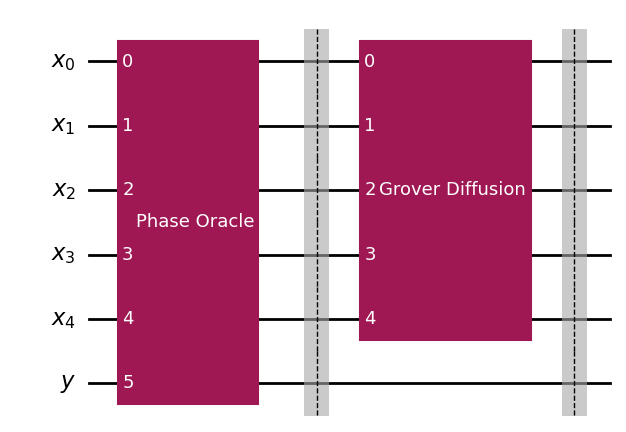

In [94]:
GroverIter(5,f).draw(output='mpl')

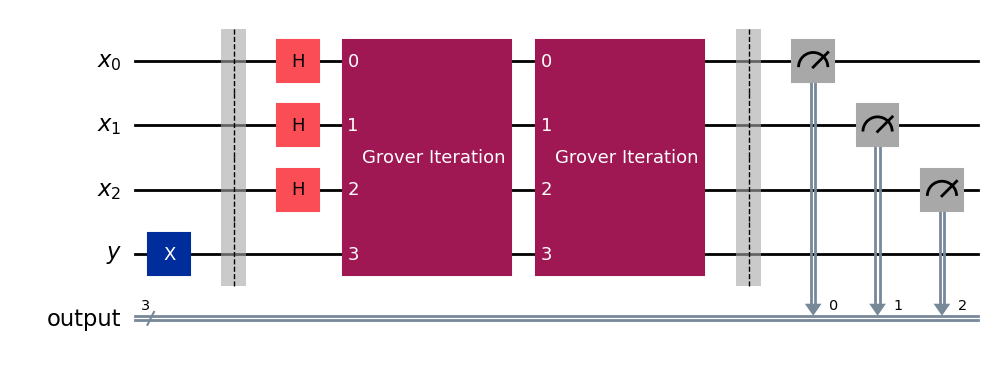

In [95]:
Grover(3,f,4).draw(output='mpl')

## Running the circuit


Let us get a histogram of the circuit.

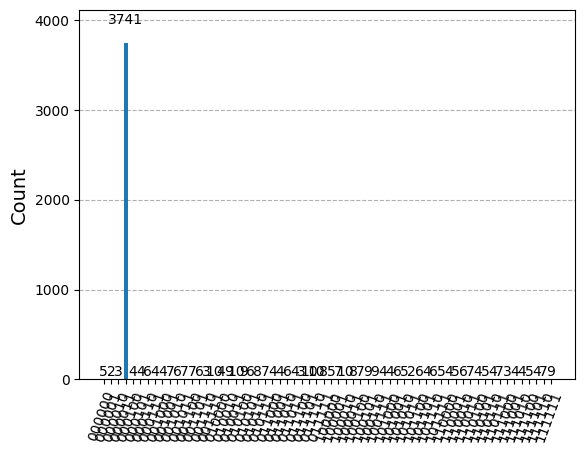

In [96]:
aer_sim = Aer.get_backend('aer_simulator')
circ = transpile(Grover(6,f,1), aer_sim)
result = aer_sim.run(circ,shots=4096).result()
statistics = result.get_counts()
plot_histogram(statistics)

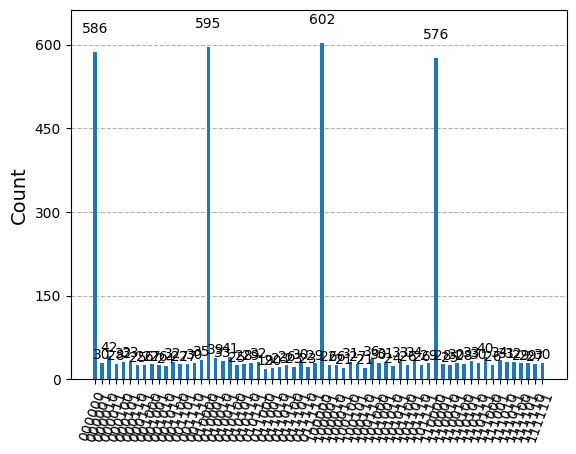

In [97]:
def g(x):
    if x%16==0:
        return 1
    return 0
circ = transpile(Grover(6,g,4), aer_sim)
result = aer_sim.run(circ,shots=4096).result()
statistics = result.get_counts()
plot_histogram(statistics)